In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

67 sessions!
67 sessions!


In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][1] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117'

In [4]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [5]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [6]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [7]:
all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)

fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

In [8]:
%%time
reload(cpacas)
edges = np.concatenate([np.linspace(0,1,10),np.arange(1,400,10)])
test_res = cpacas.sweep_test_coswitch_wrapper(data_dir_full,
                                pf_res_save_fn='place_field_avg_and_trial_vthresh.p',
                                pf_shuffle_fn = 'fr_map_null_trialtype_vthresh.p',
                                speed_key='v',
                                bin_size=2.2,
                                switch_res_query=(slice(None),0.3,'switch_magnitude',0.4),
                                nrepeats_sw = 1000,
                                edges = edges,
                                force_reload=False,
                                dosave=True,
                                )
test_res['test_res_df']

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/switch_res_window.p exists; loading---
CPU times: user 5.31 ms, sys: 4.31 ms, total: 9.61 ms
Wall time: 63.4 ms


window_low window_high count   pval    sig count_ci_low count_ci_up  \
 1 0         0.0    0.111111    63    0.0   True         20.0        43.0   
   1    0.111111    0.222222    21  0.234  False         10.0        27.0   
   2    0.222222    0.333333    22  0.039   True          7.0        23.0   
   3    0.333333    0.444444    18  0.176  False          6.0        23.0   
   4    0.444444    0.555556    20  0.117  False          7.0        23.0   
...          ...         ...   ...    ...    ...          ...         ...   
-1 44      341.0       351.0   228  0.026   True        143.0       228.0   
   45      351.0       361.0   178  0.217  False      120.975       208.0   
   46      361.0       371.0   153  0.401  False      106.975       194.0   
   47      371.0       381.0   240  0.014   True        138.0       230.0   
   48      381.0       391.0   304    0.0   True       157.95     260.025   

      window_size  window_median  baseline  
 1 0     0.111111       0.055556     39126  
   1     0.111111       0.166667     25055  
   2     0.111111       0.277778     19751  
   3     0.111111       0.388889     20469  
   4     0.111111       0.500000     20375  
...           ...            ...       ...  
-1 44        10.0     346.000000    493287  
   45        10.0     356.000000    453317  
   46        10.0     366.000000    431415  
   47        10.0     376.000000    508522  
   48        10.0     386.000000    562943  

[98 rows x 10 columns]

In [9]:
all_sw_times_v_combined = test_res['all_sw_times_v_combined']

In [18]:
test_res.keys()

dict_keys(['test_res_df', 'count_shuffle', 'all_sw_times_v_combined', 'all_fields_times_v', 'changes_df_combined', 'changes_df_combined_d', 'pf_loc_combined', 'trial_pos_info', 'pos_to_time_func_per_trial'])

In [10]:
# sampled_fields,reference_field,fields_available_for_selection = select_co_switch_pairs(all_sw_times_v_combined,thresh=1.,reference_field=(3,0),nsamples=1,time_diff=None,onoff=1,diff_key='time')
import manual_explorations as me
reload(me)
sampled_fields,reference_field,fields_available_for_selection = me.select_co_switch_pairs(all_sw_times_v_combined,thresh=1.,nsamples=1,time_diff=None,onoff=1,diff_key='time')




In [12]:
# getting fields whose switching lasts for a few trials
reload(me)
task_ind=0
field_l_d_bothtrialtypes = me.get_fields_with_lasting_switching_wrapper(switch_res,pf_res, lasting_trial_thresh=3,task_ind=task_ind)



/mnt/home/szheng/projects/util_code/manual_explorations.py:106: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)
/mnt/home/szheng/projects/util_code/manual_explorations.py:106: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


In [14]:
reference_field

(0, 35, 0)

In [13]:
%matplotlib inline
reload(me)
task_ind =0 
tt_ind = 0
coswitch_window = 1.
onoff = 1
field_l = field_l_d_bothtrialtypes[tt_ind][onoff]

nn = 2
same_trialtype_only = True
field = field_l.iloc[nn]
reference_field = (task_ind,*field.name[:2])
sampled_fields,reference_field,fields_available_for_selection = me.select_co_switch_pairs(all_sw_times_v_combined,thresh=coswitch_window,nsamples=1,reference_field=reference_field,same_trialtype_only=same_trialtype_only,time_diff=None,onoff=1,diff_key='time')


# fr_map_concat_task = fr_map_concat.loc[task_ind]
selected_fields = pd.concat([reference_field,fields_available_for_selection],axis=0)

fmt=fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)
fig,axs=me.plot_co_switch_ratemaps(selected_fields,fmt,switch_trial=field['trial'],reference_field_range=field['start':'end'].values)
axs.ravel()[0].set_title(f"trial={field['trial']},field={field.name}\ntrialtype={tt_ind}")
fig,axs=me.plot_co_switch_waveforms(cell_metrics,selected_fields,fig=None,axs=None)

fig,axs=me.plot_co_switch_waveforms(cell_metrics,selected_fields,fig=None,axs=None,plot_all_channels=True)





ValueError: Shape of passed values is (3, 1), indices imply (4, 1)

In [188]:
field_l_d_bothtrialtypes[0][-1]

start  end  com  peak    fr_peak    fr_mean  trial
29  0      1   10    5     4   8.114678   7.493030     19
30  0      1   21    8     6  10.134196   6.402575     22
31  0     71   89   80    81   7.329966   4.368296     23
35  0      1    6    3     1   5.981159   5.440014     10
36  0     15   30   22    22  22.889018  15.887205     22
...      ...  ...  ...   ...        ...        ...    ...
463 0     23   28   25    26   1.387648   1.212000      9
    1     49   56   52    53   1.105246   0.919499     16
465 0     11   34   22    21   2.176381   1.154307     16
475 0     24   42   33    36   5.028874   3.177112      7
476 0     28   40   33    29   1.152027   0.991878      1

[175 rows x 7 columns]

In [263]:
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)

,trialtype,uid,field_index
0,0,34,0
1,0,43,0
5,0,196,0
7,0,246,0


In [267]:
tuple(selected_fields.iloc[0].values)

(0, 34, 0)

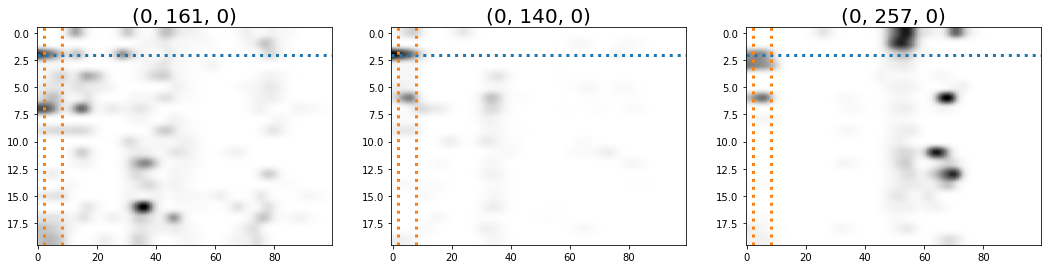

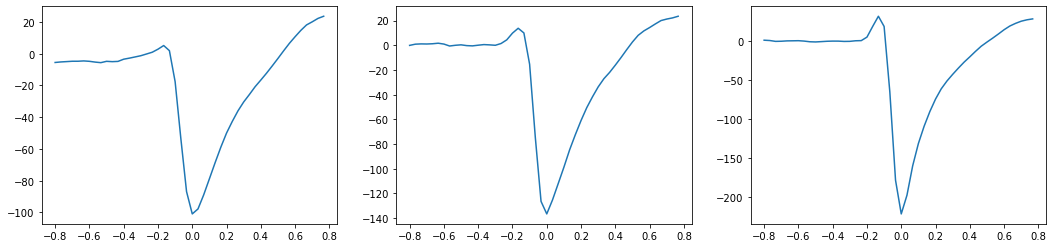

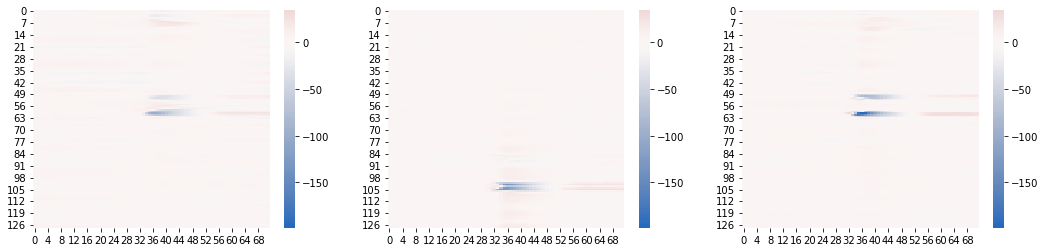

In [17]:
reload(me)
me.visualize_coswitch_wrapper(all_sw_times_v_combined,field_l_d_bothtrialtypes,cell_metrics,fr_map_trial_df_d,
                              all_fields_all_trialtype=all_fields_all_trialtype,
                              trial_index_to_index_within_df=trial_index_to_index_within_df,
                                task_ind =0 ,
                                    tt_ind = 0,
                                    coswitch_window = 1.,
                                    onoff = 1,
                                    field_index=None,
                                    reference_field=None,
                                    same_trialtype_only = True,
                                    diff_key='time'
                                )

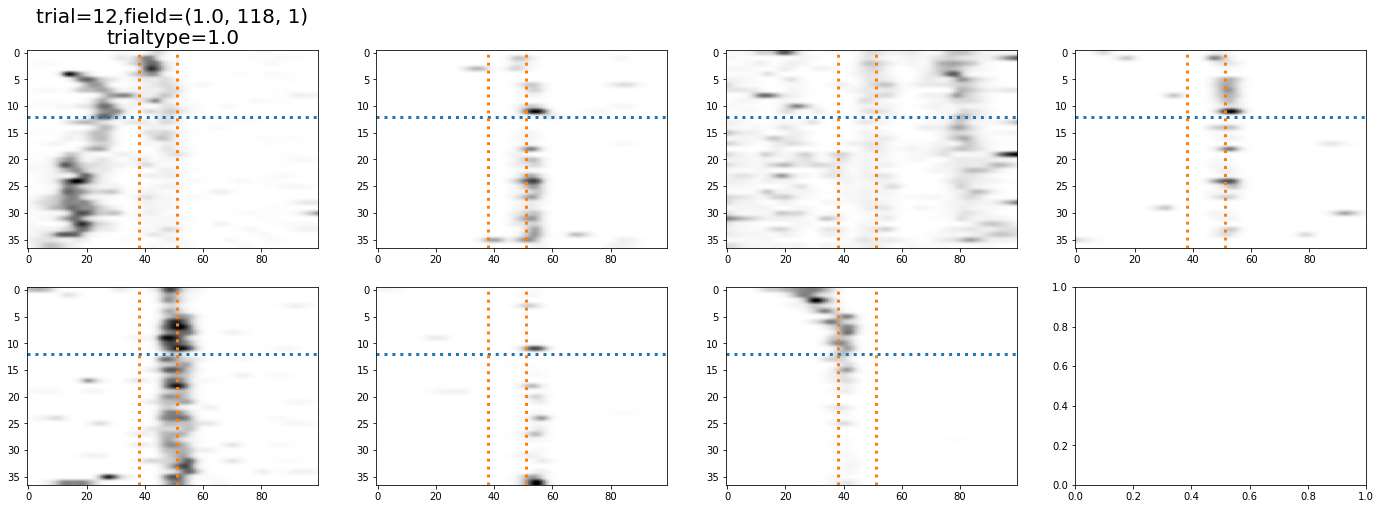

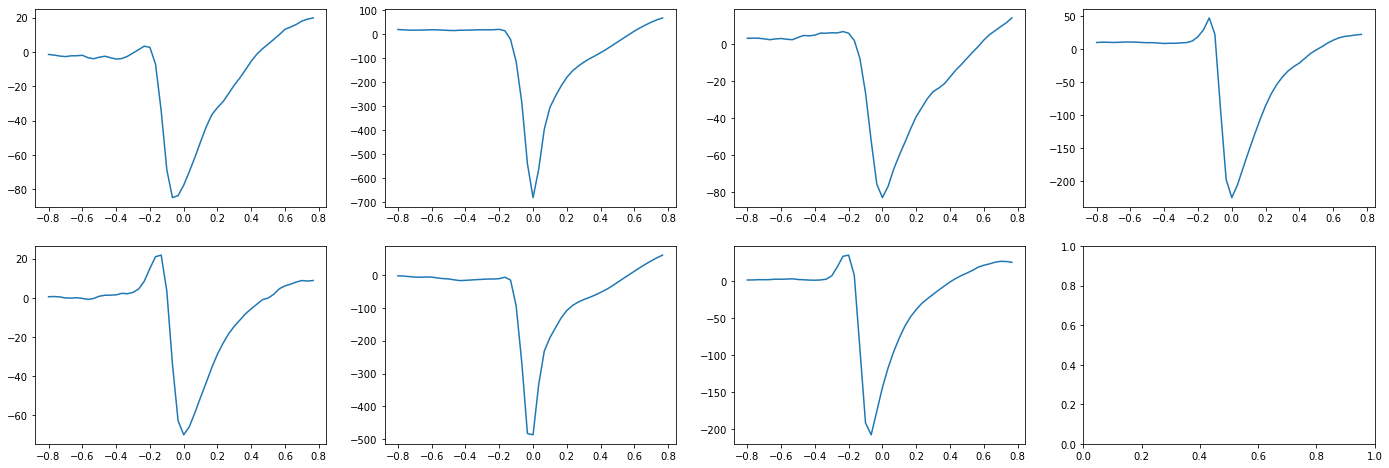

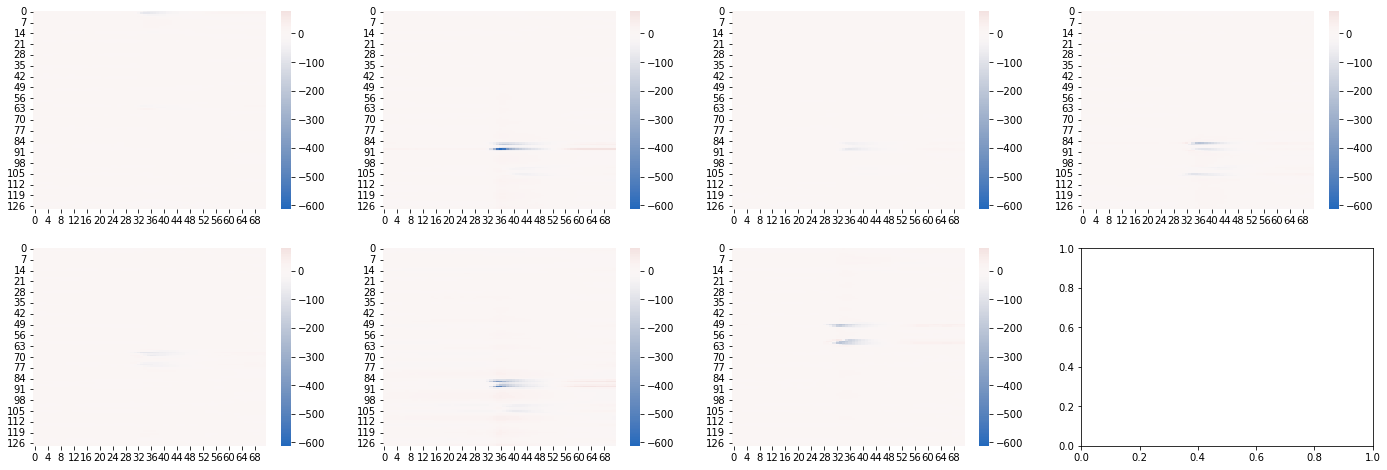

In [260]:
reload(me)
me.visualize_coswitch_wrapper(all_sw_times_v_combined,field_l_d_bothtrialtypes,cell_metrics,fr_map_trial_df_d,
                              all_fields_all_trialtype=all_fields_all_trialtype,
                              trial_index_to_index_within_df=trial_index_to_index_within_df,
                                task_ind =0 ,
                                    tt_ind = 0,
                                    coswitch_window = 1.,
                                    onoff = -1,
                                    field_index=None,
                                    reference_field=None,
                                    same_trialtype_only = True,
                                    diff_key='time'
                                )

In [229]:
all_sw_times_v_combined

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,29,1,7893.902900,36.778932,21.0,1,1.0
1,both,140,0,7893.386117,7.336045,9.0,1,1.0
2,both,455,0,7893.252750,1.939159,7.0,1,1.0
0,both,168,0,7918.842533,36.627722,23.0,2,-1.0
1,both,386,1,7918.492467,29.929168,18.0,2,1.0
...,...,...,...,...,...,...,...,...
13,1,311,1,9989.965667,21.281060,63.0,69,-1.0
14,1,378,1,9998.351117,11.046759,89.0,69,1.0
15,1,424,0,9988.131867,2.869145,51.0,69,1.0
16,1,430,1,9998.151067,7.238519,87.0,69,1.0
